In [44]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import stim
print(stim.__version__)

import matplotlib.pyplot as plt
import numpy as np
import math

from ldpc import bp_decoder, bposd_decoder
import time
from src.utils import rank
from src.codes_q import create_bivariate_bicycle_codes, create_circulant_matrix
from src.build_circuit import build_circuit, dem_to_check_matrices
from src import osd_window

"""导入我们的解码器"""
from gauss_decoder import gauss_decoder

np.random.seed(0)


1.14.0


In [ ]:
decoding_time = []


def sliding_window_decoder(
    N,
    p=0.003,
    num_repeat=12,
    num_shots=10000,
    max_iter=200,
    W=2,
    F=1,
    z_basis=True,
    noisy_prior=None,
    method=0,
    plot=False,
    # shorten=False,
    decoder_type="BP",
):

    if N == 72:
        code, A_list, B_list = create_bivariate_bicycle_codes(
            6, 6, [3], [1, 2], [1, 2], [3]
        )  # 72
    elif N == 90:
        code, A_list, B_list = create_bivariate_bicycle_codes(
            15, 3, [9], [1, 2], [2, 7], [0]
        )  # 90
    elif N == 108:
        code, A_list, B_list = create_bivariate_bicycle_codes(
            9, 6, [3], [1, 2], [1, 2], [3]
        )  # 108
    elif N == 144:
        code, A_list, B_list = create_bivariate_bicycle_codes(
            12, 6, [3], [1, 2], [1, 2], [3]
        )  # 144
    elif N == 288:
        code, A_list, B_list = create_bivariate_bicycle_codes(
            12, 12, [3], [2, 7], [1, 2], [3]
        )  # 288
    elif N == 360:
        code, A_list, B_list = create_bivariate_bicycle_codes(
            30, 6, [9], [1, 2], [25, 26], [3]
        )  # 360
    elif N == 756:
        code, A_list, B_list = create_bivariate_bicycle_codes(
            21, 18, [3], [10, 17], [3, 19], [5]
        )  # 756
    else:
        print("unsupported N")
        return

    circuit = build_circuit(code, A_list, B_list, p, num_repeat, z_basis=z_basis)
    dem = circuit.detector_error_model()
    chk, obs, priors, col_dict = dem_to_check_matrices(dem, return_col_dict=True)
    num_row, num_col = chk.shape
    n = code.N
    n_half = n // 2

    lower_bounds = []
    upper_bounds = []
    i = 0
    while i < num_row:
        lower_bounds.append(i)
        upper_bounds.append(i + n_half)
        if i + n > num_row:
            break
        lower_bounds.append(i)
        upper_bounds.append(i + n)
        i += n_half

    region_dict = {}
    for i, (l, u) in enumerate(zip(lower_bounds, upper_bounds)):
        region_dict[(l, u)] = i

    region_cols = [[] for _ in range(len(region_dict))]

    for i in range(num_col):
        nnz_col = np.nonzero(chk[:, i])[0]
        l = nnz_col.min() // n_half * n_half
        u = (nnz_col.max() // n_half + 1) * n_half
        region_cols[region_dict[(l, u)]].append(i)

    chk = np.concatenate([chk[:, col].toarray() for col in region_cols], axis=1)
    obs = np.concatenate([obs[:, col].toarray() for col in region_cols], axis=1)
    priors = np.concatenate([priors[col] for col in region_cols])

    anchors = []
    j = 0
    for i in range(num_col):
        nnz_col = np.nonzero(chk[:, i])[0]
        if nnz_col.min() >= j:
            anchors.append((j, i))
            j += n_half
    anchors.append((num_row, num_col))

    if noisy_prior is None and method != 0:
        b = anchors[W]
        c = anchors[W - 1]
        if method == 1:
            c = (c[0], c[1] + n_half * 3) if z_basis else (c[0], c[1] + n)
        #             c = (c[0], c[1]+n_half*3) # try also this for x basis, change the later one as well
        noisy_prior = np.sum(
            chk[c[0] : b[0], c[1] : b[1]] * priors[c[1] : b[1]], axis=1
        )
        print("prior for noisy syndrome", noisy_prior[0])

    if method != 0:
        noisy_syndrome_priors = np.ones(n_half) * noisy_prior

    num_win = math.ceil((len(anchors) - W + F - 1) / F)
    chk_submats = []
    prior_subvecs = []
    if plot:
        fig, ax = plt.subplots(num_win, 1)
    top_left = 0
    i = 0
    for i in range(num_win):
        a = anchors[top_left]
        bottom_right = min(top_left + W, len(anchors) - 1)
        b = anchors[bottom_right]

        if i != num_win - 1 and method != 0:  # not the last round
            c = anchors[top_left + W - 1]
            if method == 1:
                c = (c[0], c[1] + n_half * 3) if z_basis else (c[0], c[1] + n)
            #                 c = (c[0], c[1]+n_half*3) # try also this for x basis, change the previous one as well
            noisy_syndrome = np.zeros((n_half * W, n_half))
            noisy_syndrome[-n_half:, :] = np.eye(n_half)  # * noisy_syndrome_prior
            mat = chk[a[0] : b[0], a[1] : c[1]]
            mat = np.hstack((mat, noisy_syndrome))
            prior = priors[a[1] : c[1]]
            prior = np.concatenate((prior, noisy_syndrome_priors))
        else:  # method==0 or last round
            mat = chk[a[0] : b[0], a[1] : b[1]]
            prior = priors[a[1] : b[1]]
        chk_submats.append(mat)
        prior_subvecs.append(prior)
        if plot:
            ax[i].imshow(mat, cmap="gist_yarg")
        top_left += F

    start_time = time.perf_counter()
    dem_sampler: stim.CompiledDemSampler = dem.compile_sampler()
    det_data, obs_data, err_data = dem_sampler.sample(
        shots=num_shots, return_errors=False, bit_packed=False
    )
    end_time = time.perf_counter()
    print(
        f"Stim: noise sampling for {num_shots} shots, Elapsed time:",
        end_time - start_time,
    )

    total_e_hat = np.zeros((num_shots, num_col))
    new_det_data = det_data.copy()
    start_time = time.perf_counter()
    top_left = 0
    # 分窗口进行解码，提升效率
    for i in range(num_win):
        mat = chk_submats[i]
        prior = prior_subvecs[i]
        a = anchors[top_left]
        bottom_right = min(top_left + W, len(anchors) - 1)
        b = anchors[bottom_right]
        c = anchors[top_left + F]  # commit region bottom right

        """choose decoder"""
        if decoder_type == "BP":
            bpd = bposd_decoder(
                mat,  # the parity check matrix
                error_rate=p,  # does not matter because channel_probs is assigned
                channel_probs=prior,  # assign error_rate to each qubit. This will override "error_rate" input variable
                max_iter=max_iter,  # the maximum number of iterations for BP)
                bp_method="minimum_sum_log",
                ms_scaling_factor=1.0,  # min sum scaling factor. If set to zero the variable scaling factor method is used
                osd_method="osd_cs",
                osd_order=-1,  # -1 for no osd (only BP)
                input_vector_type="syndrome",
            )
        if decoder_type == "BP_OSD":
            bpd = bposd_decoder(
                mat,  # the parity check matrix
                error_rate=p,  # does not matter because channel_probs is assigned
                channel_probs=prior,  # assign error_rate to each qubit. This will override "error_rate" input variable
                max_iter=max_iter,  # the maximum number of iterations for BP)
                bp_method="minimum_sum_log",
                ms_scaling_factor=1.0,  # min sum scaling factor. If set to zero the variable scaling factor method is used
                osd_method="osd_0",
                osd_order=7,  # -1 for no osd (only BP)
                input_vector_type="syndrome",
            )
        if decoder_type == "OSD_WIN":  # run my version of OSD
            # if after `pre_max_iter` BP iterations on the original PCM but not converged
            # sort according to sum of the recent four posterior_llr from low to high
            # pick the first `new_n` columns, default to 2*num_row
            # run BP for `post_max_iter` iterations then OSD on the shortened window
            # only support `min_sum_log` syndrome decoding
            bpd = osd_window(
                mat,
                channel_probs=prior,
                pre_max_iter=8,  # BP preprocessing on original PCM
                post_max_iter=max_iter,  # BP on shortened PCM
                ms_scaling_factor=1.0,
                new_n=None,  # if set to None, 2*num_row columns will be kept
                osd_method="osd_cs",
                osd_order=10,
            )
        if decoder_type == "OUR":
            mat = mat.astype(int)
            bpd = gauss_decoder(mat, error_rate=p)
            print(f"mat = {mat}, mat shape = {mat.shape}")
            bpd.pre_decode()

        # 判断当前窗口是否解码成功。每个窗口内解码num_shots次
        num_flag_err = 0
        detector_win = new_det_data[:, a[0] : b[0]]
        for j in range(num_shots):
            decoding_start_time = time.perf_counter()
            # print(f"detector_win[j] = {detector_win[j]}")
            syndrome = [1 if item else 0 for item in detector_win[j]]
            # print(f"syndrome = {syndrome}")
            e_hat = bpd.decode(syndrome)  # detector_win[j] is syndrome, len == m

            decoding_end_time = time.perf_counter()
            # if shorten: print(f"pm: {bpd.min_pm}")
            decoding_time.append(decoding_end_time - decoding_start_time)
            is_flagged = ((mat @ e_hat + detector_win[j]) % 2).any()
            num_flag_err += is_flagged
            if i == num_win - 1:  # last window
                total_e_hat[j][a[1] : b[1]] = e_hat
            else:
                total_e_hat[j][a[1] : c[1]] = e_hat[: c[1] - a[1]]

        print(f"Window {i}, flagged Errors: {num_flag_err}/{num_shots}")

        new_det_data = (det_data + total_e_hat @ chk.T) % 2
        top_left += F

    end_time = time.perf_counter()
    print("Elapsed time:", end_time - start_time)

    flagged_err = ((det_data + total_e_hat @ chk.T) % 2).any(axis=1)
    num_flagged_err = flagged_err.astype(int).sum()
    print(f"Overall Flagged Errors: {num_flagged_err}/{num_shots}")
    logical_err = ((obs_data + total_e_hat @ obs.T) % 2).any(axis=1)
    num_err = np.logical_or(flagged_err, logical_err).astype(int).sum()
    print(f"Logical Errors: {num_err}/{num_shots}")
    p_l = num_err / num_shots
    p_l_per_round = 1 - (1 - p_l) ** (1 / num_repeat)
    # may also use ** (1/(num_repeat-1))
    # because the first round is for encoding, the next (num_repeat-1) rounds are syndrome measurements rounds
    print("logical error per round:", p_l_per_round)

In [46]:
# Our decoder
sliding_window_decoder(
    N=144,
    p=0.004,
    num_repeat=12,
    W=3,
    F=1,
    num_shots=10000,
    max_iter=200,
    method=1,
    z_basis=True,
    decoder_type="OUR",
)

plt.hist([x * 1000 for x in decoding_time])  # convert s to ms

prior for noisy syndrome 0.036622121785736664
Stim: noise sampling for 10000 shots, elapsed time: 0.04987590100063244
mat = [[1 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]], mat shape = (216, 1656)
find zero rows: 0
hz trans rank 216, original 216
B shape = (216, 1440)


KeyboardInterrupt: 

prior for noisy syndrome 0.036622121785736664
Stim: noise sampling for 10000 shots, elapsed time: 0.049856407000334
Window 0, flagged Errors: 1904/10000
Window 1, flagged Errors: 2319/10000
Window 2, flagged Errors: 2641/10000
Window 3, flagged Errors: 2888/10000
Window 4, flagged Errors: 3128/10000
Window 5, flagged Errors: 3221/10000
Window 6, flagged Errors: 3410/10000
Window 7, flagged Errors: 3446/10000
Window 8, flagged Errors: 3513/10000
Window 9, flagged Errors: 3494/10000
Window 10, flagged Errors: 2226/10000
Elapsed time: 835.6065475080104
Overall Flagged Errors: 4676/10000
Logical Errors: 4676/10000
logical error per round: 0.05117415936452874


(array([6.5477e+04, 7.3500e+03, 2.4440e+03, 1.2930e+03, 1.3080e+03,
        1.9615e+04, 1.2437e+04, 6.0000e+01, 1.1000e+01, 5.0000e+00]),
 array([ 0.109566  ,  3.5647299 ,  7.0198938 , 10.4750577 , 13.93022159,
        17.38538549, 20.84054939, 24.29571329, 27.75087719, 31.20604109,
        34.66120499]),
 <BarContainer object of 10 artists>)

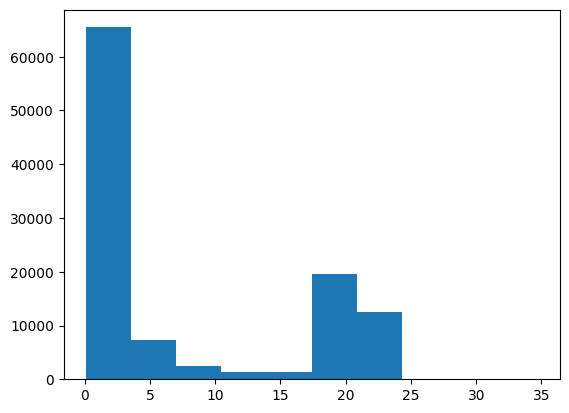

In [3]:
# BP
sliding_window_decoder(
    N=144,
    p=0.004,
    num_repeat=12,
    W=3,
    F=1,
    num_shots=10000,
    max_iter=200,
    method=1,
    z_basis=True,
    decoder_type="BP",
)

plt.hist([x * 1000 for x in decoding_time])  # convert s to ms

prior for noisy syndrome 0.036622121785736664
Stim: noise sampling for 10000 shots, elapsed time: 0.049607906010351144
Window 0, flagged Errors: 0/10000
Window 1, flagged Errors: 0/10000
Window 2, flagged Errors: 0/10000
Window 3, flagged Errors: 0/10000
Window 4, flagged Errors: 0/10000
Window 5, flagged Errors: 0/10000
Window 6, flagged Errors: 0/10000
Window 7, flagged Errors: 0/10000
Window 8, flagged Errors: 0/10000
Window 9, flagged Errors: 0/10000
Window 10, flagged Errors: 0/10000
Elapsed time: 698.3799864310131
Overall Flagged Errors: 0/10000
Logical Errors: 506/10000
logical error per round: 0.004317741042643264


(array([1.42991e+05, 1.41530e+04, 4.68200e+03, 2.52200e+03, 2.37130e+04,
        2.92020e+04, 2.28000e+03, 3.15000e+02, 1.19000e+02, 2.30000e+01]),
 array([ 0.109566  ,  4.0808693 ,  8.0521726 , 12.0234759 , 15.9947792 ,
        19.9660825 , 23.9373858 , 27.9086891 , 31.8799924 , 35.85129571,
        39.82259901]),
 <BarContainer object of 10 artists>)

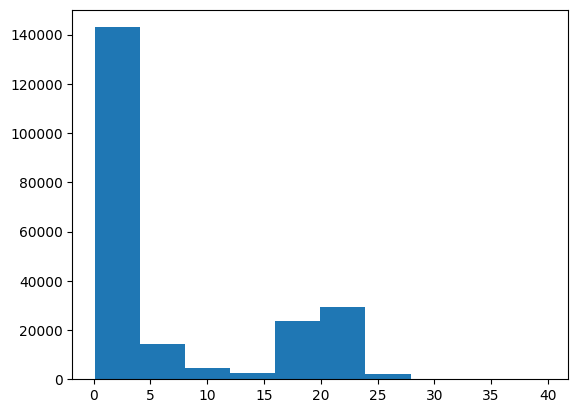

In [4]:
# BP+OSD
sliding_window_decoder(
    N=144,
    p=0.004,
    num_repeat=12,
    W=3,
    F=1,
    num_shots=10000,
    max_iter=200,
    method=1,
    z_basis=True,
    decoder_type="BP_OSD",
)

plt.hist([x * 1000 for x in decoding_time])  # convert s to ms

In [ ]:
# OSD with shortened window
sliding_window_decoder(
    N=144,
    p=0.004,
    num_repeat=12,
    W=3,
    F=1,
    num_shots=10000,
    max_iter=200,
    method=1,
    z_basis=True,
    decoder_type="OSD_WIN",
)

plt.hist([x * 1000 for x in decoding_time])  # convert s to ms

prior for noisy syndrome 0.036622121785736664
Stim: noise sampling for 10000 shots, elapsed time: 0.057349747003172524
e_hat = [0 0 0 ... 0 0 0]
mat.shape = (216, 1656)
detector_win[j] = [False  True False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False  True  True False  True False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False  True
 False False False False False False False False False False  True False
 False  True False False  True False False False  True False False False
 False  True False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False  True  True False  True  True  True False
 False Fal